In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet

# MobileNet was designed to work on 224 x 224 pixel input image sizes
img_rows, img_cols = 224, 224

# Re-load the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False

# Let's print our layers
for i, layer in enumerate(MobileNet.layers):
    print(f"{i} {layer.__class__.__name__}, Trainable: {layer.trainable}")


0 InputLayer, Trainable: False
1 Conv2D, Trainable: False
2 BatchNormalization, Trainable: False
3 ReLU, Trainable: False
4 DepthwiseConv2D, Trainable: False
5 BatchNormalization, Trainable: False
6 ReLU, Trainable: False
7 Conv2D, Trainable: False
8 BatchNormalization, Trainable: False
9 ReLU, Trainable: False
10 ZeroPadding2D, Trainable: False
11 DepthwiseConv2D, Trainable: False
12 BatchNormalization, Trainable: False
13 ReLU, Trainable: False
14 Conv2D, Trainable: False
15 BatchNormalization, Trainable: False
16 ReLU, Trainable: False
17 DepthwiseConv2D, Trainable: False
18 BatchNormalization, Trainable: False
19 ReLU, Trainable: False
20 Conv2D, Trainable: False
21 BatchNormalization, Trainable: False
22 ReLU, Trainable: False
23 ZeroPadding2D, Trainable: False
24 DepthwiseConv2D, Trainable: False
25 BatchNormalization, Trainable: False
26 ReLU, Trainable: False
27 Conv2D, Trainable: False
28 BatchNormalization, Trainable: False
29 ReLU, Trainable: False
30 DepthwiseConv2D, Traina

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet


# Set the input shape based on MobileNet's requirements
input_shape = (224, 224, 3)

# Instantiate MobileNet with the desired input shape
base_model = MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)

# Set the number of classes
num_classes = 5

# Add the fully connected head to the base model
FC_Head = lw(base_model, num_classes)

# Create the final model
model = Model(inputs=base_model.input, outputs=FC_Head)

# Set all layers in the model as trainable
for layer in model.layers:
    layer.trainable = True

# Print the model summary
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use raw strings to avoid issues with backslashes
train_data_dir = '/content/drive/MyDrive/Emojify/train/'
validation_data_dir = '/content/drive/MyDrive/Emojify/validation/'


# Let's use some data augmentaiton
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 16

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')


Found 1000 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the file path for saving the best model
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Emojify/emojify.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# Define early stopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# Put the callbacks into a list
callbacks = [earlystop, checkpoint]

# Compile the model with the Adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer
              metrics=['accuracy'])

# Set the number of training and validation samples
nb_train_samples = 1000
nb_validation_samples = 250

# Define the number of epochs and batch size
epochs = 20
batch_size = 16

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)


Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8911
Epoch 1: val_loss improved from inf to 10.01492, saving model to /content/drive/MyDrive/Emojify/emojify.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 27s 126ms/step - loss: 0.4165 - accuracy: 0.8911 - val_loss: 10.0149 - val_accuracy: 0.4042
Epoch 2/20
62/62 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9746
Epoch 2: val_loss improved from 10.01492 to 0.93528, saving model to /content/drive/MyDrive/Emojify/emojify.h5
62/62 [==============================] - 7s 113ms/step - loss: 0.0931 - accuracy: 0.9746 - val_loss: 0.9353 - val_accuracy: 0.6375
Epoch 3/20
62/62 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9949
Epoch 3: val_loss improved from 0.93528 to 0.61073, saving model to /content/drive/MyDrive/Emojify/emojify.h5
62/62 [==============================] - 8s 125ms/step - loss: 0.0150 - accuracy: 0.9949 - val_loss: 0.6107 - val_accuracy: 0.7958
Epoch 4/20
62/62 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9970
Epoch 4: val_loss did not improve from 0.61073
62/62 [==============================] - 6s 91ms/step -

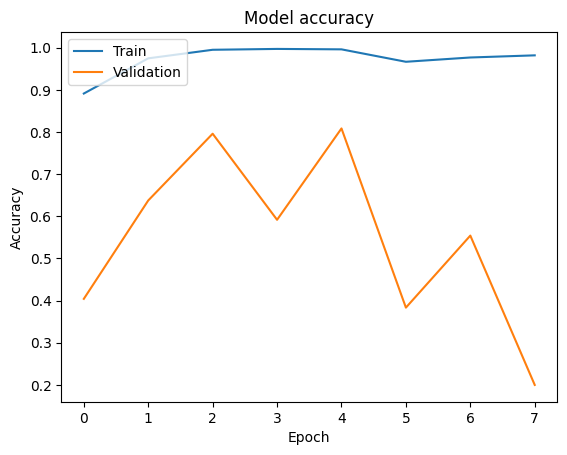

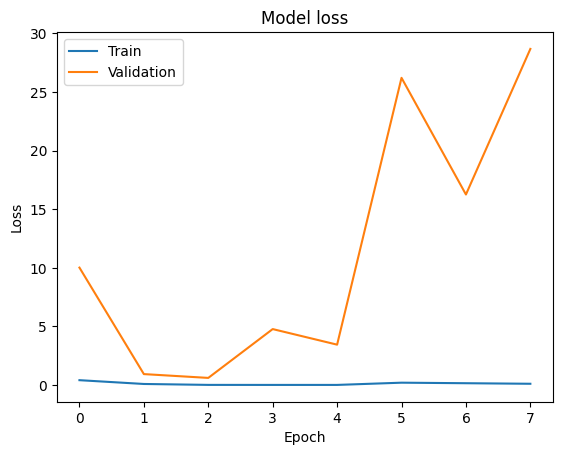

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
